# Multi-channel ANN
## Number of channels: 2 

In [12]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
years = '2021-05-2022-05'
df = pd.read_csv('./data/' + years + '_all.csv')

def rename_column(data):
    return data.rename(columns={'평균 수온(°C)':'temperature'}, inplace=True)

df['일시'] = df['Unnamed: 0']
df = df.drop(columns='Unnamed: 0')
df['일시'] = pd.to_datetime(df['일시'])
df.set_index('일시',inplace=True)
rename_column(df)
data = df
display(df.head())

,temperature
일시,
2021-05-31,18.2
2021-06-01,18.6
2021-06-02,18.9
2021-06-03,18.3
2021-06-04,18.5


In [14]:
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

def r2_score(y_pred, y_true):
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [15]:
import copy

window_size = 12
m_data = copy.deepcopy(data)
m_data['rolling_mean'] = m_data.rolling(window_size).mean()
rename_column(m_data)
m_data

,temperature,rolling_mean
일시,,
2021-05-31,18.2,NaN
2021-06-01,18.6,NaN
2021-06-02,18.9,NaN
2021-06-03,18.3,NaN
2021-06-04,18.5,NaN
...,...,...
2022-05-27,18.1,17.450000
2022-05-28,18.4,17.633333
2022-05-29,18.8,17.791667


<Axes: xlabel='일시'>

/home/estsoft/miniconda3/envs/tw/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
/home/estsoft/miniconda3/envs/tw/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/home/estsoft/miniconda3/envs/tw/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/estsoft/miniconda3/envs/tw/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


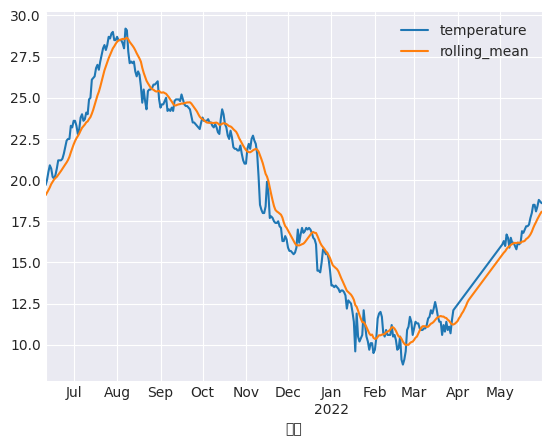

In [16]:
m_data = m_data.dropna()
m_data.plot()

In [17]:
m_data

,temperature,rolling_mean
일시,,
2021-06-11,19.7,19.083333
2021-06-12,20.0,19.233333
2021-06-13,20.5,19.391667
2021-06-14,20.9,19.558333
2021-06-15,20.7,19.758333
...,...,...
2022-05-27,18.1,17.450000
2022-05-28,18.4,17.633333
2022-05-29,18.8,17.791667


In [18]:
class TimeSeriesDatasetMulti(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    # self.data = ts.reshape(-1, 2)  # 데이터를 2차원 배열로 변환
    self.data = ts

  # 예측할 전체 데이터셋의 개수
  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1

  def __getitem__(self, i):
    idx = (i + self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx + self.forecast_size]
    return look_back, forecast

In [19]:
pred_size = 20
lookback_size = 15
forecast_size = 5
lr = 0.0001

In [20]:
scaler = MinMaxScaler()
m_trn_scaled = scaler.fit_transform(m_data[:-pred_size].to_numpy(dtype=np.float32))
m_tst_scaled = scaler.transform(m_data[-pred_size-lookback_size:].to_numpy(dtype=np.float32))

m_trn_df = m_data[:-pred_size].to_numpy(dtype=np.float32)
m_tst_df = m_data[-pred_size - lookback_size:].to_numpy(dtype=np.float32)
m_tst_y = m_tst_df[-pred_size:]

def collate_fn(batch):
    look_back_list, forecast_list = zip(*batch)
    look_back = torch.tensor(look_back_list)
    forecast = torch.tensor(forecast_list)
    return look_back, forecast

### 스케일 안한 케이스
m_trn_Ods = TimeSeriesDatasetMulti(m_trn_df, lookback_size, forecast_size)
m_tst_Ods = TimeSeriesDatasetMulti(m_tst_df, lookback_size, forecast_size)

m_trn_Odl = DataLoader(m_trn_Ods, batch_size=32, shuffle=True)
m_tst_Odl = DataLoader(m_tst_Ods, batch_size=pred_size, shuffle=False)

#### 스케일 한 케이스
m_trn_ds = TimeSeriesDatasetMulti(m_trn_scaled, lookback_size, forecast_size)
# tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

m_trn_dl = DataLoader(m_trn_ds, batch_size=32, shuffle=True)
# tst_dl = DataLoader(tst_ds, batch_size=pred_size, shuffle=False)

In [21]:
x, y = next(iter(m_trn_Odl))
print(x.shape, y.shape)

torch.Size([32, 15, 2]) torch.Size([32, 5, 2])


In [22]:
class NetMulti(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, c_in, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in*c_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out*c_in) # out = 5, c = 2
    self.activation = activation
    self.c_in = c_in
    self.d_out = d_out
    
  def forward(self, x):
    x = x.flatten(1)
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x).reshape(-1, self.d_out, self.c_in) # 1 => (32, 10)
    return x

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = NetMulti(lookback_size, forecast_size, 512, 2)
net.to(device)

optim = torch.optim.AdamW(net.parameters(), lr=lr)
epoch = 1500
pbar = trange(epoch)

losses = []
trn_losses = []

for i in pbar:
  net.train()
  trn_loss = .0

  for x, y in m_trn_Odl: # 여기 2가지 케이스
    x, y = x.to(device), y.to(device)   # (32,15,2), (32, 5,2) in 32줄 (총 326개)
    # print('------------ flatten -------------')
    # print(x.flatten(1))
    # print('------------- net ------------')
    p = net(x)    # (32, 15, 2)인 predict output
    optim.zero_grad()
    loss = F.mse_loss(p, y)   # pred 와 target 차이
    loss.backward()
    optim.step()
    trn_loss += loss.item() * len(y)
  trn_loss = trn_loss / len(m_trn_Ods) # 여기 2가지 케이스

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(m_tst_Odl)) # 여기 2가지 케이스
    x, y = x.to(device), y.to(device)     # x: input(20, 15, 2), y: target(5)
    p = net(x)
    tst_loss = F.mse_loss(p, y)
    y = y.cpu()
    p = p.cpu()
    tst_mape = mape(p, y)
    tst_mae = mae(p, y)

  pbar.set_postfix({'Multi-channel loss':trn_loss, 'tst_loss':tst_loss.item(), 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})
  tst_loss = tst_loss.cpu()
  losses.append(tst_loss)
  trn_losses.append(trn_loss)

100%|██████████| 1500/1500 [00:51<00:00, 29.14it/s, Multi-channel loss=0.367, tst_loss=0.119, tst_mape=1.34, tst_mae=0.234]


<function matplotlib.pyplot.show(close=None, block=None)>

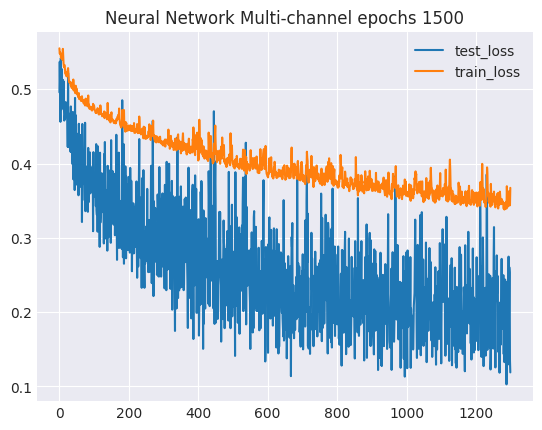

In [28]:
plt.title(f"Neural Network Multi-channel epochs {epoch}")
plt.plot(losses[200:], label='test_loss')
plt.plot(trn_losses[200:], label='train_loss')
plt.legend()
plt.savefig('./result/ANN_2multi-channel_loss'+ years +'_'+str(epoch)+'.png')
plt.show

In [29]:
preds = []

x, y = m_trn_Ods[len(m_trn_Ods)-1]  #마지막의 input(15개), output(5개) 값을 가져옴
# print(f'x: {x}, y: {y}\n')
# print(x.shape, y.shape)

net.eval()
for _ in range(int(pred_size/forecast_size)):
  if y.shape == (1, 5, 2):
    y = y.squeeze(0)
  x = np.concatenate([x, y])[-lookback_size:]   # x = 20개[-15:] 즉, 15개
  x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
  with torch.inference_mode():
    y = net(x_tensor).cpu()
  preds.append(y)

print(f'\nlen(preds): {len(preds)}\n')  # len(preds) = 4 개 (for문 range만큼)

preds = np.concatenate(preds)  # 예측 결과값을 하나의 Numpy 배열로 병합
print(f'preds: {preds}')    # 4개(5개씩)를 합치므로 4x5 = 20개
final_preds = preds[:,:,0].flatten()  # rolling_mean 컬럼 제외하고 기존 컬럼으로만 담기


len(preds): 4

preds: [[[16.45521  16.180458]
  [16.561234 16.27045 ]
  [16.611568 16.306932]
  [16.760214 16.38817 ]
  [16.75886  16.41825 ]]

 [[16.901234 16.455544]
  [17.00205  16.48843 ]
  [17.12285  16.553812]
  [17.130648 16.638493]
  [17.076849 16.77719 ]]

 [[17.264713 16.7752  ]
  [17.39828  16.9082  ]
  [17.426619 16.988855]
  [17.435915 17.0529  ]
  [17.351305 17.160208]]

 [[17.576244 17.15244 ]
  [17.6927   17.25634 ]
  [17.738173 17.305576]
  [17.771452 17.404522]
  [17.698572 17.496656]]]


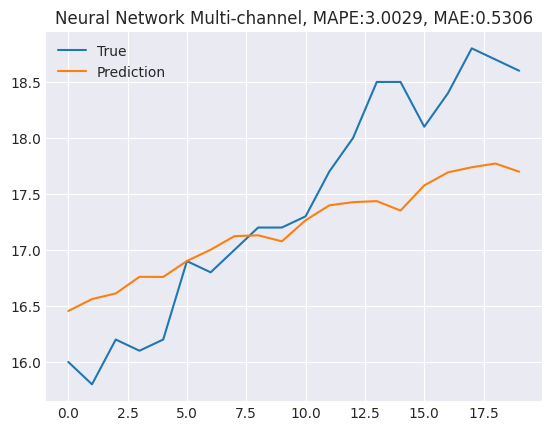

In [30]:
plt.title(f"Neural Network Multi-channel, MAPE:{mape(final_preds,m_tst_y[:,0]):.4f}, MAE:{mae(final_preds,m_tst_y[:,0]):.4f}")
plt.plot(range(pred_size), m_tst_y[:,0], label="True")
plt.plot(range(pred_size), final_preds, label="Prediction")
plt.legend()
plt.savefig(f'./result/ANN_2multi_loss_{years}_({pred_size},{lookback_size},{forecast_size})_{epoch}_{lr}.png')
plt.show()